## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import KernelPCA

In [3]:
# Printing current directory
import os
current_directory = os.getcwd()
print("Current directory is ", current_directory)

Current directory is  /content


In [4]:
bank = pd.read_csv('/content/sample_data/Bank Customer Churn.csv')
print(bank)

      RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMemb

## Converting Gender into a binary variable

In [5]:
# Convert Gender into a binary variable

# First, define a dictionary to map gender to binary values
gender_map = {'Male':0, 'Female':1}

# Next, apply map to Gender column
bank['Gender'] = bank['Gender'].map(gender_map)

print(bank['Gender'])

0       1
1       1
2       1
3       1
4       1
       ..
9995    0
9996    0
9997    1
9998    0
9999    1
Name: Gender, Length: 10000, dtype: int64


## One-hot encode Card Type and Geography

In [6]:
# One-hot encode Card Type and Geography
cols_to_encode = ['Card Type', 'Geography']
data_to_encode = bank[cols_to_encode]

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)

# Fits the encoder to the selected columns and transform them
encoded_data = one_hot_encoder.fit_transform(data_to_encode)

# Create a dataframe from the encoded data
# Retrieves the feature names from one_hot_encoder, use get_feature_names_out()
encoded_df = pd.DataFrame(encoded_data, columns = one_hot_encoder.get_feature_names_out())

# Columns: axis=1
# Rows: axis=0
bank = pd.concat([bank.drop(cols_to_encode, axis = 1), encoded_df], axis = 1)
print(bank)

      RowNumber  CustomerId    Surname  CreditScore  Gender  Age  Tenure  \
0             1    15634602   Hargrave          619       1   42       2   
1             2    15647311       Hill          608       1   41       1   
2             3    15619304       Onio          502       1   42       8   
3             4    15701354       Boni          699       1   39       1   
4             5    15737888   Mitchell          850       1   43       2   
...         ...         ...        ...          ...     ...  ...     ...   
9995       9996    15606229   Obijiaku          771       0   39       5   
9996       9997    15569892  Johnstone          516       0   35      10   
9997       9998    15584532        Liu          709       1   36       7   
9998       9999    15682355  Sabbatini          772       0   42       3   
9999      10000    15628319     Walker          792       1   28       4   

        Balance  NumOfProducts  HasCrCard  ...  Complain  Satisfaction Score  \
0      

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
bank = bank.drop(columns = ['RowNumber', 'CustomerId', 'Surname'])

# There are 1,000 rows and 16 variables after dropping 2
print(bank.shape)
print(bank.columns)

(10000, 20)
Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
       'Satisfaction Score', 'Point Earned', 'Card Type_DIAMOND',
       'Card Type_GOLD', 'Card Type_PLATINUM', 'Card Type_SILVER',
       'Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype='object')


## Checking for missing values

In [12]:
# Check for missing values
# No missing values
bank.isnull().sum()

CreditScore           0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Point Earned          0
Card Type_DIAMOND     0
Card Type_GOLD        0
Card Type_PLATINUM    0
Card Type_SILVER      0
Geography_France      0
Geography_Germany     0
Geography_Spain       0
dtype: int64

There are 5 binary variables:
* Complain
* Exited
* HasCrCard
* IsActiveMember
* Gender

There are 2 ordinal variables:
* Satisfaction score
* Card Type

There is 1 nominal variable:
* Geography

There are 7 numeric variables:
* CreditScore
* Age
* Tenure
* Balance
* NumofProducts
* EstimatedSalary
* Point Earned

## Summary statistics

In [ ]:
# Summary statistics to check for anomalies
summary_stats = bank.describe()
print(summary_stats)

## Plotting correlation matrix

In [ ]:
# Plot correlation matrix
# np.triu extracts the upper triangle of an array, includes main diagonal by default
# np.ones_like(matrix, dtype = bool) creates a boolean array with the same shape as matrix where all elements are true
# np.triu(np.ones_like(matrix, dtype = bool)) applies upper triangle mask to this boolean array,
# setting all elements in the lower triangle to False
# mask - data will not be shown in cells where mask is true

corr_matrix = bank.corr(method = 'pearson')

# np.ones_like(corr_matrix, dtype=bool) creates an array of ones with the same shape and data type as the corr_matrix
# np.triu(...) returns the upper triangle of an array and sets the lower triangle and the diagonal to zero
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
threshold= np.abs(corr_matrix) >= 0.2

sns.heatmap(corr_matrix,
            cmap = sns.diverging_palette(20, 220, n=7),
            annot = True,
            annot_kws = {'size':7},
            fmt=".1f",  # Format to two decimal places
            vmin = -1,
            vmax = 1,
            mask = mask)

It seems like Exited and Complain has a high correlation coefficient. However, both variables are binary, using Pearson correlation will not give us an accurate result. Hence using Phi coefficient might give us a more accurate result.
(Phi coefficient for binary variables with 2 levels, Cramer's V for variables with more than 2 levels)
* 1 indicates perfect positive correlation
* -1 indicates perfect negative correlation
*0 indicates no correlation

* The following Phi coefficient shows that Exited and Complain has a strong positive correlation of 0.99. Hence, Complain might be an important variable in predicting Exited

In [23]:
a = bank[(bank['Exited'] == 0) & (bank['Complain'] == 0)]
len_a = len(a)

In [24]:
b = bank[(bank['Exited'] == 0) & bank['Complain'] == 1]
len_b = len(b)

In [25]:
c = bank[(bank['Exited'] == 1) & (bank['Complain'] == 0)]
len_c = len(c)

In [26]:
d = bank[(bank['Exited'] == 1) & (bank['Complain'] == 1)]
len_d = len(d)

In [27]:
len_a + len_b + len_c + len_d

10000

In [28]:
# Create a phi coefficient Function
'''
This function calculates the phi coefficient for 2 binary variables
a represents the frequency of cases where both variables are 0
b represents the frequency of cases where var 1 is 0 and var 2 is 1
c represents the frequency of cases where var 1 is 1 and var 2 is 0
d represents the frequency of cases where var 1 and var 2 are 1
'''
def phi_coeff(a, b, c, d):
  numerator = (a*d) - (b*c)
  val = (a+b) * (c+d) * (a+c) * (b+d)
  denominator = np.sqrt(val)
  phi = numerator / denominator
  return phi


In [29]:
phi = phi_coeff(len_a, len_b, len_c, len_d)
print('The correlation between Exited and Complain is:', phi)

The correlation between Exited and Complain is: 0.9956925015718875


## Correlation between Exited and HasCrCard

In [30]:
a = bank[(bank['Exited'] == 0) & (bank['HasCrCard'] == 0)]
len_a = len(a)

b = bank[(bank['Exited'] == 0) & bank['HasCrCard'] == 1]
len_b = len(b)

c = bank[(bank['Exited'] == 1) & (bank['HasCrCard'] == 0)]
len_c = len(c)

d = bank[(bank['Exited'] == 1) & (bank['HasCrCard'] == 1)]
len_d = len(d)

len_a + len_b + len_c + len_d

phi = phi_coeff(len_a, len_b, len_c, len_d)
print('The correlation between Exited and HasCrCard is:', phi)

The correlation between Exited and HasCrCard is: -0.006976070976576953


## Correlation between Exited and IsActiveMember

In [31]:
a = bank[(bank['Exited'] == 0) & (bank['IsActiveMember'] == 0)]
len_a = len(a)

b = bank[(bank['Exited'] == 0) & bank['IsActiveMember'] == 1]
len_b = len(b)

c = bank[(bank['Exited'] == 1) & (bank['IsActiveMember'] == 0)]
len_c = len(c)

d = bank[(bank['Exited'] == 1) & (bank['IsActiveMember'] == 1)]
len_d = len(d)

len_a + len_b + len_c + len_d

phi = phi_coeff(len_a, len_b, len_c, len_d)
print('The correlation between Exited and IsActiveMember is:', phi)

The correlation between Exited and IsActiveMember is: -0.15635563349849269


## Correlation between Exited and Gender

In [32]:
a = bank[(bank['Exited'] == 0) & (bank['Gender'] == 0)]
len_a = len(a)

b = bank[(bank['Exited'] == 0) & bank['Gender'] == 1]
len_b = len(b)

c = bank[(bank['Exited'] == 1) & (bank['Gender'] == 0)]
len_c = len(c)

d = bank[(bank['Exited'] == 1) & (bank['Gender'] == 1)]
len_d = len(d)

len_a + len_b + len_c + len_d

phi = phi_coeff(len_a, len_b, len_c, len_d)
print('The correlation between Exited and Gender is:', phi)

The correlation between Exited and Gender is: 0.10626653301252878


In [7]:
bank[bank['Exited']==1]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,1,5,DIAMOND,484
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,1,2,DIAMOND,282
16,17,15737452,Romeo,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1,0,2,SILVER,163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,9982,15672754,Burbidge,498,Germany,Male,42,3,152039.70,1,1,1,53445.17,1,1,3,GOLD,790
9982,9983,15768163,Griffin,655,Germany,Female,46,7,137145.12,1,1,0,115146.40,1,1,4,GOLD,591
9991,9992,15769959,Ajuluchukwu,597,France,Female,53,4,88381.21,1,1,0,69384.71,1,1,3,GOLD,369
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564


## Plotting Histogram

In [33]:
bank.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
       'Satisfaction Score', 'Point Earned', 'Card Type_DIAMOND',
       'Card Type_GOLD', 'Card Type_PLATINUM', 'Card Type_SILVER',
       'Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype='object')

There is class imbalance as there are more customers who has not exited in the dataset

In [34]:
len(bank[bank['Exited'] == 1]) , len(bank[bank['Exited'] == 0])

(2038, 7962)

## Density plot
* Individuals who have exited has lower credit score in general as compared to individuals who have yet exited.
* Majority of those who has exited are in the age range of 40 to 50
* Those who exited has shorter periods of using the bank's services
* Very often, those who exited has a credit card with lower balances and are not active members, points earned is also significantly lower.
* Estimate salary of those who left are much lower than those who stayed

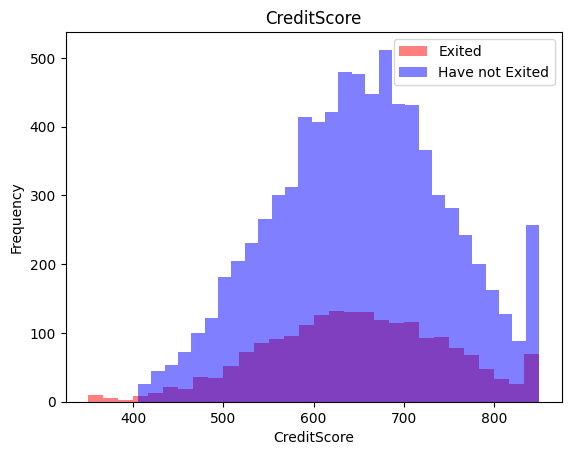

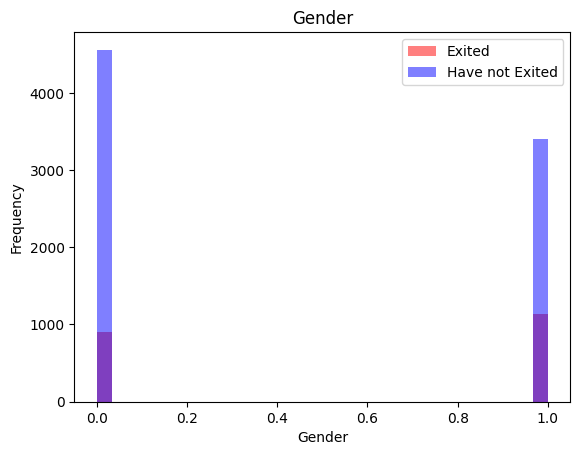

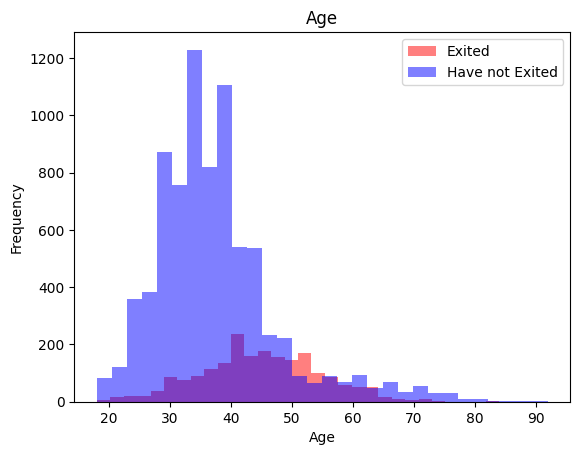

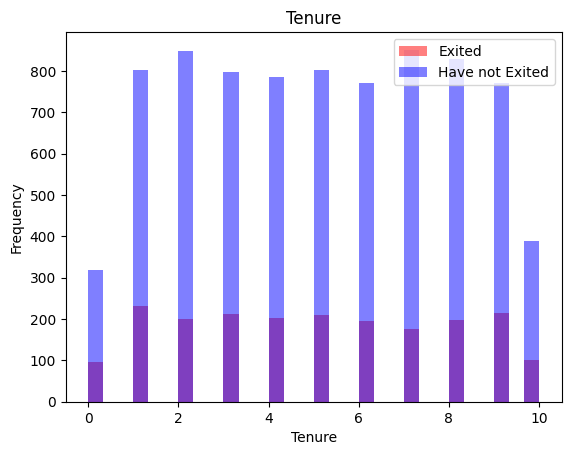

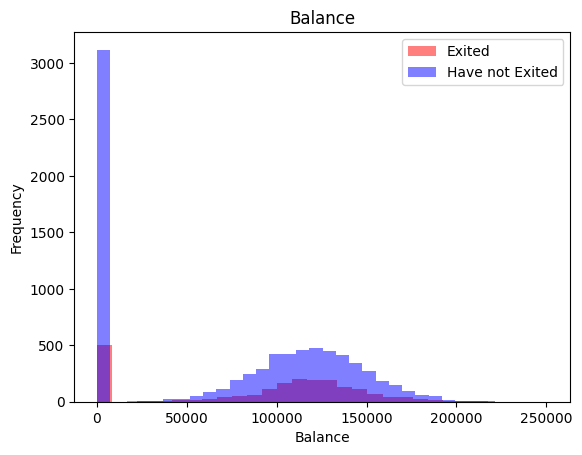

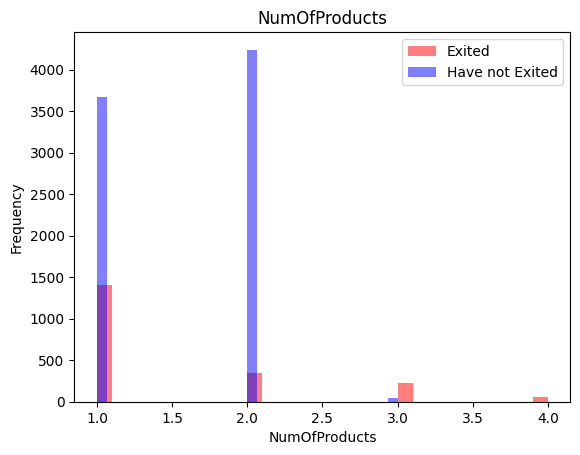

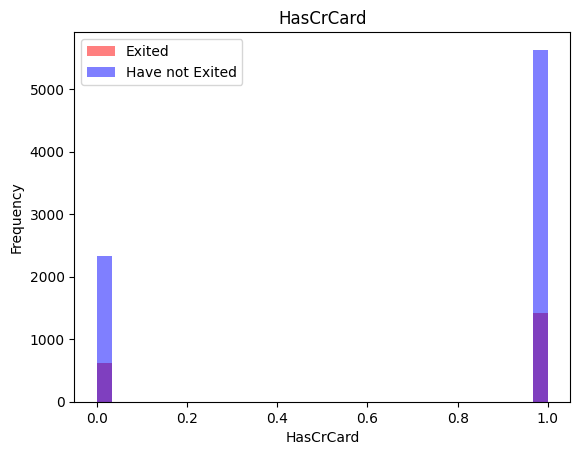

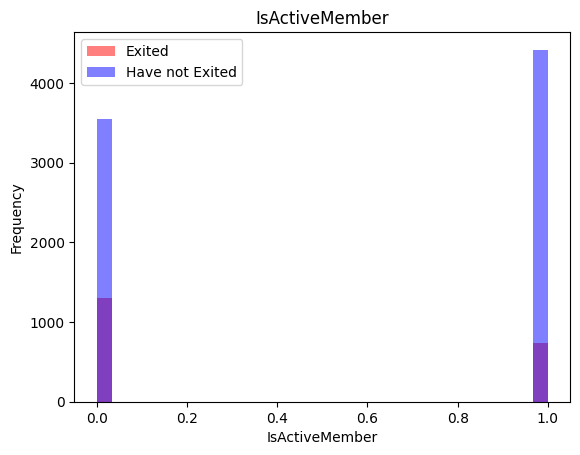

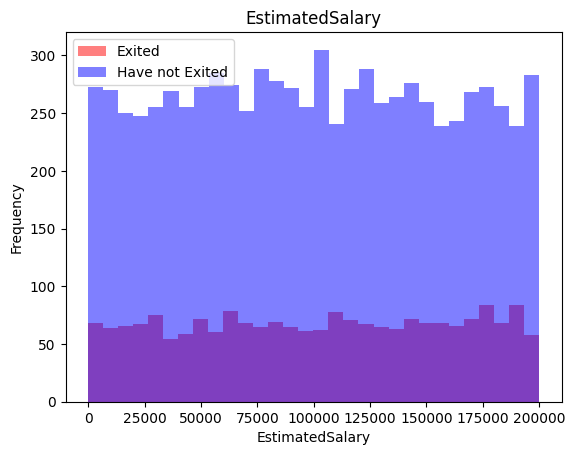

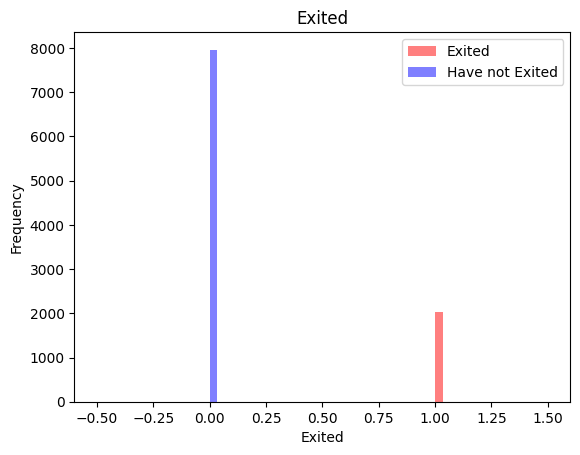

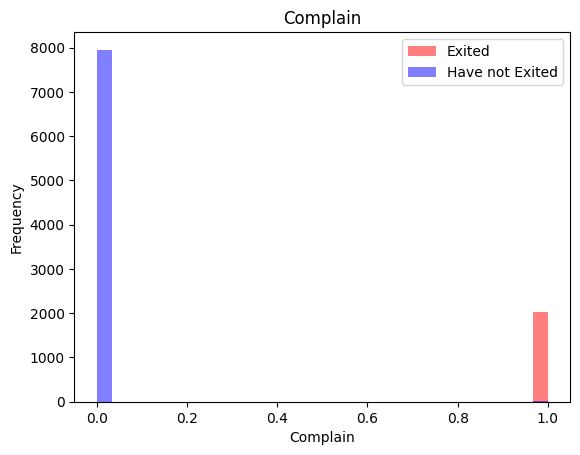

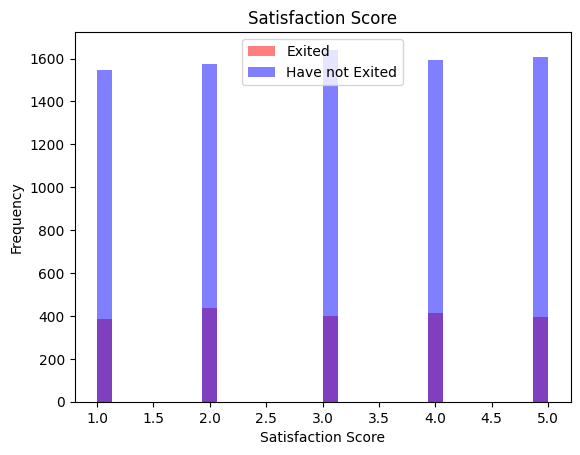

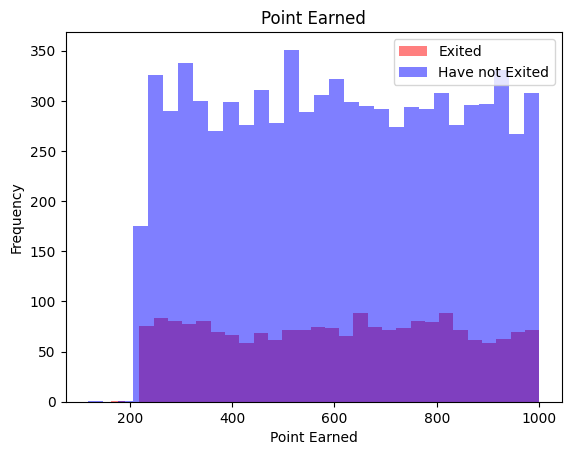

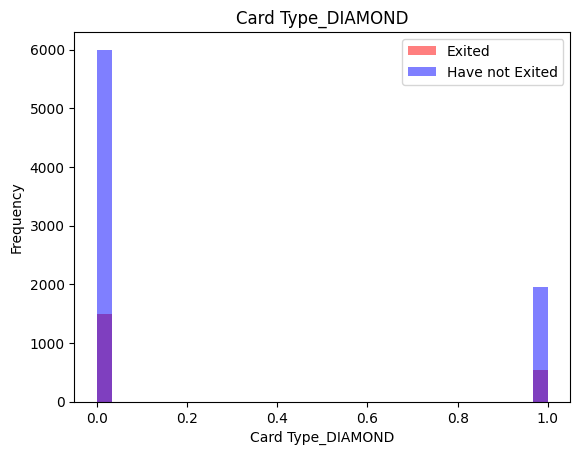

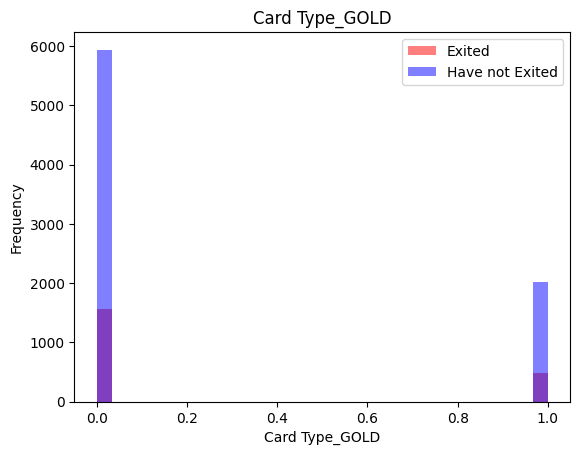

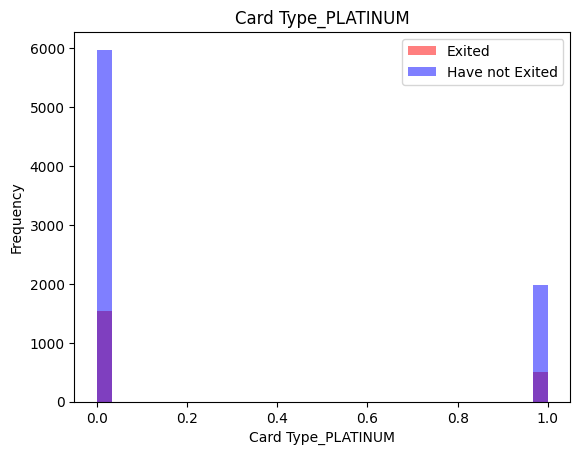

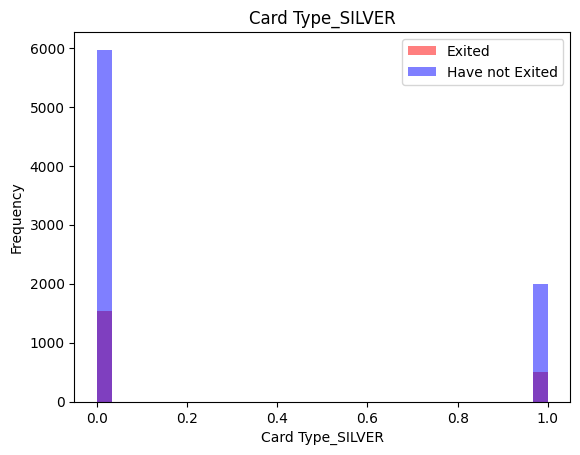

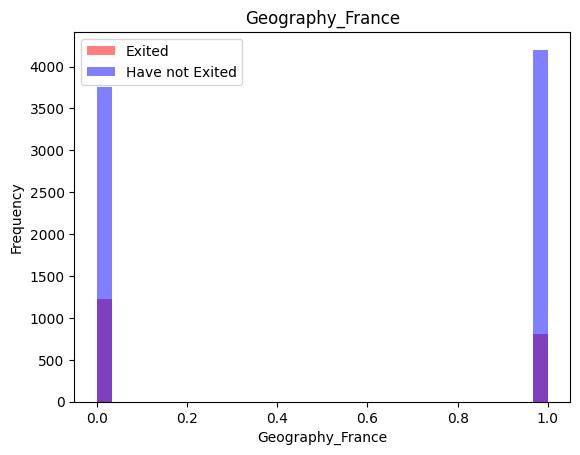

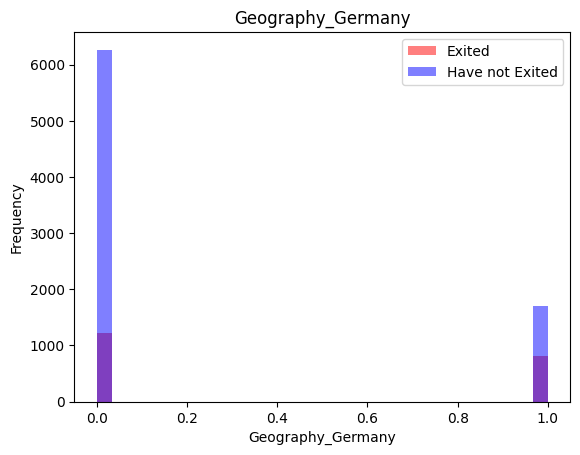

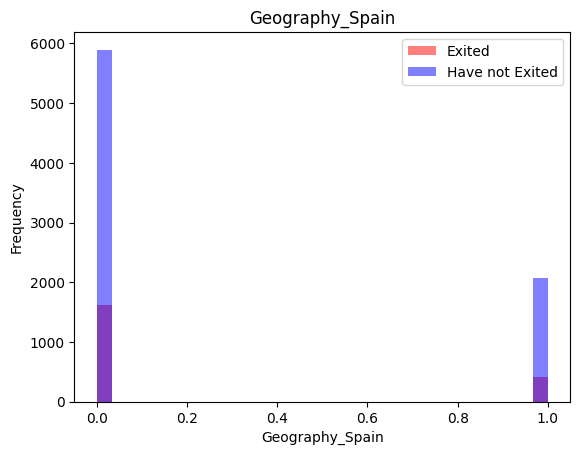

In [12]:
# density = True means that the height of the y-axis is normalised such that the area under the histogram is 1
# The y-axis represents the probabiity density function rather than the actual probability density

for i in bank.columns:
  label = i
  plt.hist(bank[bank['Exited'] == 1][i], bins = 30, density = False, color = 'red', alpha = 0.5, label = 'Exited')
  plt.hist(bank[bank['Exited'] == 0][i], bins = 30, density = False, color = 'blue', alpha = 0.5, label = 'Have not Exited')
  plt.title(label),
  plt.xlabel(label),
  plt.ylabel('Frequency'),
  plt.legend()
  plt.show()

## Satisfaction score of customers who have exited
* Surprisingly, there is no trend in the plot
* Despite having a satisfaction score of 5, customers still chose to leave the bank.
* Distribution seems to be quite uniform across all scores

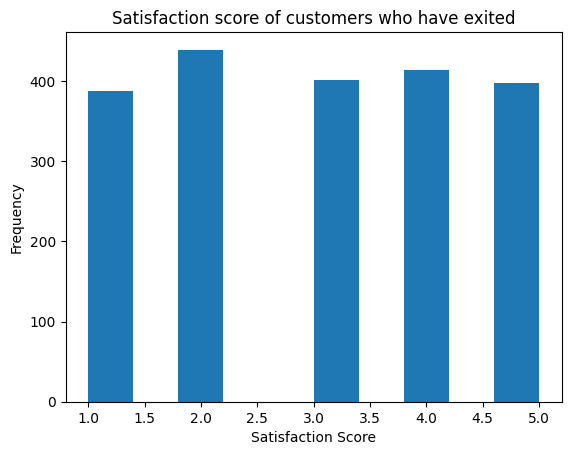

In [38]:
exited_satis = bank[bank['Exited']==1]['Satisfaction Score']

plt.hist(exited_satis)
plt.title('Satisfaction score of customers who have exited')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
plt.show()

## Number of complaints among customers who have exited
* It seems that most customers filed a complaint before leaving the company
* Only 4 customers did not file a complaint before leaving

Number of customer who did not file a complaint before leaving: 4


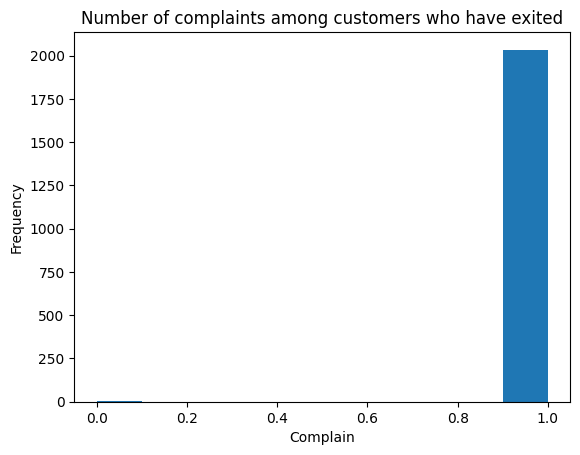

In [37]:
exited_complain = bank[bank['Exited']==1]['Complain']
plt.hist(exited_complain)
plt.title('Number of complaints among customers who have exited')
plt.xlabel('Complain')
plt.ylabel('Frequency')

print('Number of customer who did not file a complaint before leaving:', len(bank[(bank['Exited']==1) & (bank['Complain']==0)]))

## Card type of customers who left
* A greater number of customers who left has diamond card, while almost an equal number had Gold, Platinum and Silver cards

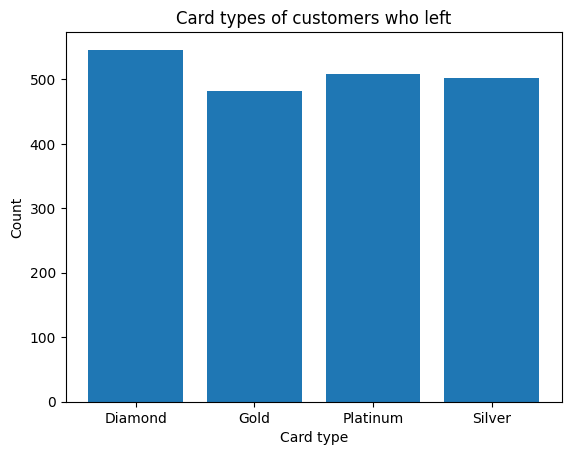

In [8]:
diamond_exited = len(bank[(bank['Exited']==1) & (bank['Card Type_DIAMOND'])])
gold_exited = len(bank[(bank['Exited']==1) & (bank['Card Type_GOLD'])])
platinum_exited = len(bank[(bank['Exited']==1) & (bank['Card Type_PLATINUM'])])
silver_exited = len(bank[(bank['Exited']==1) & (bank['Card Type_SILVER'])])

card_type=['Diamond','Gold','Platinum','Silver']
exited_counts=[diamond_exited,gold_exited,platinum_exited,silver_exited]

plt.bar(card_type,exited_counts)
plt.title('Card types of customers who left')
plt.xlabel('Card type')
plt.ylabel('Count')
plt.show()

## Geography of customers who exited

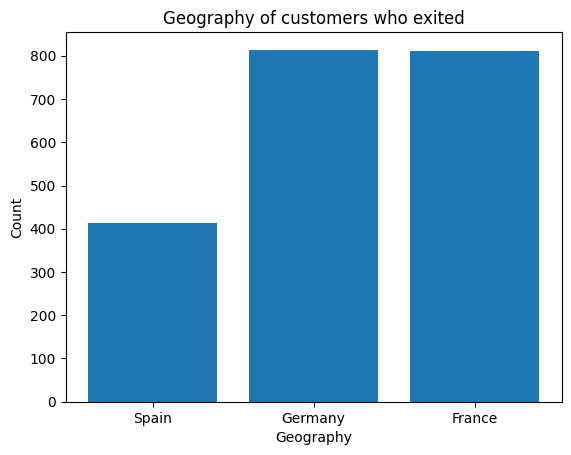

In [9]:
spain_exited = len(bank[(bank['Exited']==1) & (bank['Geography_Spain'])])
germany_exited = len(bank[(bank['Exited']==1) & (bank['Geography_Germany'])])
france_exited = len(bank[(bank['Exited']==1) & (bank['Geography_France'])])


geography_type=['Spain','Germany','France']
exited_counts=[spain_exited,germany_exited,france_exited]

plt.bar(geography_type,exited_counts)
plt.title('Geography of customers who exited')
plt.xlabel('Geography')
plt.ylabel('Count')
plt.show()

## Splitting data into testing, validation and training data

In [9]:
X = pd.concat([bank[bank.columns[0:9]], bank[bank.columns[11:20]]], axis = 1)
y = bank['Exited']

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Logistic regression
 * The logistic model has failed to identify 363 individuals who has exited, making 100% error rate which is too high to be accepted.
 * Since there is class imbalance, the classes are too well seperated with 2038 individuals default on the loan and 7962 individuals who did not default on the loan, Logistic regression might not be the best model.
 * About 20% of the individual has exited, hence it is not suprising that a simple logistic model has an overall error rate of 0.1965

In [11]:
sum(bank['Exited']==1),sum(bank['Exited']==0)

(2038, 7962)

In [12]:
2038/(2038+7962)

0.2038

In [13]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)
predict_prob = log_model.predict_proba(X_train)

# Create a DataFrame with the predicted and actual labels
df = pd.DataFrame({'Predicted':y_pred, 'Actual':y_test})

table = pd.crosstab(df['Predicted'], df['Actual'])
print(table)

error_rate = (table.loc[0,1])/sum(sum(table.values))
print('\nThe overall error rate is:', error_rate)

Actual        0    1
Predicted           
0          1607  393

The overall error rate is: 0.1965


## Linear Discriminant Analysis
 * Determine if it will perform better than logistic in the case of well seperated data
 * LDA performs slightly better in terms of misclassifying individuals who has exited. 302<393
 * False negative decreases from 100% to 76.8%
 * However, there is a trade off as false positive error rate increases
 * Overall error rate 0.187 is slightly lower than logistic regression 0.1965
 * LDA is better than Logistic Regression

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_predc2 = lda_model.predict(X_test)

# First column shows prob of first class (negative)
# Second column shows prob of second class (postive)
y_predp2 = lda_model.predict_proba(X_test)

# Create a DataFrame with the predicted and actual labels
df2 = pd.DataFrame({'Predicted':y_predc2, 'Actual':y_test})

table2 = pd.crosstab(df2['Predicted'], df2['Actual'])
print(table2)

error_rate2 = (table2.loc[1,0]+table2.loc[0,1])/sum(sum(table2.values))
print('Total error rate is:', error_rate2)
false_neg = table2.loc[0,1]/sum(table2.loc[:,1])
print('False negative is:',false_neg)

Actual        0    1
Predicted           
0          1535  302
1            72   91
Total error rate is: 0.187
False negative is: 0.7684478371501272


## Lowering threshold to 0.3 to be more conservative in classifying individuals

* False negetive error rate decreases even further from 76.8% to 47.5% at the expense of slightly increasing the overall error rate from 0.187 to 0.208

In [17]:
threshold = 0.3
y_pred2_th = (y_predp2[:,1]>threshold).astype(int)

# Create dataframe with new predicted class and actual
df2 = pd.DataFrame({'Predicted':y_pred2_th, 'Actual':y_test})
table2 = pd.crosstab(df2['Predicted'], df2['Actual'])
print(table2)

error_rate2 = (table2.loc[1,0]+table2.loc[0,1])/sum(sum(table2.values))
print('\nTotal error rate is:', error_rate2)
false_neg = table2.loc[0,1]/sum(table2.loc[:,1])
print('False negative is:',false_neg)

Actual        0    1
Predicted           
0          1378  187
1           229  206

Total error rate is: 0.208
False negative is: 0.4758269720101781


## Cross validation to find the best threshold value in LDA


In [96]:
len(X_train), len(bank), len(X_test), len(X_val)

(6400, 10000, 2000, 1600)

In [97]:
lowest_falseneg = 1
best_threshold = 0.5
lowest_overall = 0

for threshold in np.linspace(0.1,0.5, num=5):
  threshold = threshold
  lda_model = LinearDiscriminantAnalysis()
  lda_model.fit(X_train, y_train)
  y_predp2 = lda_model.predict_proba(X_val)
  y_pred2_th = (y_predp2[:,1]>threshold).astype(int)

  df2 = pd.DataFrame({'Predicted':y_pred2_th, 'Actual':y_val})
  table2 = pd.crosstab(df2['Predicted'], df2['Actual'])
  error_rate2 = (table2.loc[1,0]+table2.loc[0,1])/sum(sum(table2.values))
  false_neg = table2.loc[0,1]/sum(table2.loc[:,1])

  if error_rate2 < lowest_falseneg:
    lowest_falseneg = false_neg
    best_threshold = threshold
    lowest_overall = error_rate2
    print(table2)


print('\nThe lowest false negative error rate is:',lowest_falseneg)
print('With threshold:',best_threshold)
print('Hence the overall error rate of LDA model is:',lowest_overall)

Actual       0    1
Predicted          
0          506   26
1          767  301

The lowest false negative error rate is: 0.07951070336391437
With threshold: 0.1
Hence the overall error rate of LDA model is: 0.495625


## Quadratic Discriminant Analysis
* This model assumes variance covariance matrix are different for all the classes.
* Since PCA suggest that the variance-covariance matrix for all classes might be the same. Hence, LDA might perform better than QDA

In [18]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)

y_predc3 = qda_model.predict(X_test)

df3 = pd.DataFrame({'Predicted':y_predc3, 'Actual':y_test})
table3 = pd.crosstab(df3['Predicted'], df3['Actual'])
print(table3)

error_rate3 = (table3.loc[0,1]+table3.loc[1,0])/sum(sum(table3.values))
false_neg = table3.loc[0,1]/sum(table3.loc[:,1])

print('\nThe overall error rate of QDA model is:', error_rate3)
print('The false negetive rate is:', false_neg)

Actual        0    1
Predicted           
0          1607  390
1             0    3

The overall error rate of QDA model is: 0.195
The false negetive rate is: 0.9923664122137404


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## Support Vector Machine
* The cost parameter (Cost POV) is the trade-off between maximizing the margin (lower risk of overfitting, but less accurate) and minimizing misclassification error rate. When cost parameter is high, margin is smaller, missclassification error is lower.

* With the deault cost function = 1.0

* It seems that SVM with linear kernel does not perform better than LDA or QDA
* It is possible that a linear boundary might not be the best way to seperate the classes

In [123]:
from sklearn.svm import SVC

svm_linear = SVC(kernel='linear', C=10)
svm_linear.fit(X_train, y_train)

SVC(C=10, kernel='linear')

In [124]:
y_predc4 = svm_linear.predict(X_test)

df4 = ({'Predicted':y_predc4, 'Actual':y_test})
table4 = pd.crosstab(df4['Predicted'], df4['Actual'])
print(table4)

false_neg = table4.loc[0,1]/sum(table4.loc[:,1].values)
print('The false negative error rate is:', false_neg)

error_rate4 = (table4.loc[0,1]+table4.loc[1,0])/sum(sum(table4.values))
print('The overall error rate is:', error_rate4)

# Calculate the margin
# 1. Get the coefficients (weights) of the hyperplane and the intercept from the trained SVM model
weights = svm_linear.coef_[0]
intercept = svm.intercept_[0]

# 2. Calculate the magnitude of the coefficients to normalize them
magnitude_weights = np.linalg.norm(weights)

# 3. Calculate the margin
margin = 2 / magnitude_weights

print("Margin:", margin)

Exited     0    1
row_0            
0       1558  369
1         49   24
The false negative error rate is: 0.9389312977099237
The overall error rate is: 0.209


In [143]:
# Calculate the margin
# 1. Get the coefficients (weights) of the hyperplane and the intercept from the trained SVM model
weights = svm_linear.coef_[0]
intercept = svm_linear.intercept_[0]

# 2. Calculate the magnitude of the coefficients to normalize them
magnitude_weights = np.linalg.norm(weights)

# 3. Calculate the margin
margin = 2 / magnitude_weights

print("Margin:", margin)

Margin: 0.00023535141503203198


## Principal Component Analysis

In [130]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Increasing the number of principal components does not help to increase the variance explained by each principal component. Since PCA captures the linear relationship in the dataset, it is not effective to capture non-linear relationships.

In [140]:
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(X_scaled) # (10000, 2)

# Create a dataframe for principal components
pca_df = pd.DataFrame(data = principal_components, columns = ['PCA 1', 'PCA 2'])
print(pca_df)

variance_explain = pca.explained_variance_ratio_
print('\nVariance explain by PC1 & PC2 are:', variance_explain, 'respectively.')

         PCA 1     PCA 2
0    -1.292141 -0.513138
1     0.800070  1.653596
2    -0.709072 -0.562348
3    -1.577647 -0.396506
4     1.080657  1.390791
...        ...       ...
9995 -1.634463 -0.112627
9996 -1.169361 -0.544319
9997 -1.531415 -0.590682
9998  1.512944 -0.260376
9999 -0.290471 -1.420226

[10000 rows x 2 columns]



Variance explain by PC1 & PC2 are: [0.10387662 0.08340749] respectively.


## Visualize loadings

In [137]:
# To access loadings use pca.components_
loadings = pca.components_.T
print(loadings.shape) # 18 variables and 2 PCA

features = X.columns
loadings_df = pd.DataFrame(loadings, columns = ['PC1 Loading', 'PC2 Loading'], index = features)

#fig = px.scatter(pca_df, x=pca_df['PCA 1'], y=pca_df['PCA 2'], title='PCA Biplot')
#fig.show()

fig = px.scatter(loadings_df,
                 x='PC1 Loading', y='PC2 Loading', text=loadings_df.index,
                 title = 'PCA Loadings Biplot',
                 labels = {'PC1 Loading': 'PC1 Loading', 'PC2 Loading': 'PC2 Loading'}
                 )

#fig = px.scatter(x=pca_df['PCA 1'], y=pca_df['PCA 2'], title='PCA Loadings Biplot')
# Add arrows representing loadings
for feature, row in loadings_df.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[0, row['PC1 Loading']],
            y=[0, row['PC2 Loading']],
            mode = 'lines+markers',
            marker = dict(color='black', size=5),
            name = feature,
            showlegend = False,
            hoverinfo = 'skip'
        )
    )

fig.show()

(18, 2)


## Kernal PCA implementation
Non-linear functions includes:
 * Radial Basis Function (RBF) Kernel
  * Measure the similarity of the datapoints using Euclidean distance.
  * Includes a parameter to control the width of the kernel
  * Data points that are close to each other in the input space will have high similarity resulting in large kernel value
 * Polynomial Kernel
  * Captures polynomial relationship between data points
 * Signmoid Kernel
  * Captures S shape relationship between data points

In [ ]:
# gamma is the Kernel coefficient for rbf, poly and sigmoid kernels

kpca = KernelPCA(kernel = 'rbf', gamma = 16, n_components = 2)
kpca_components = kpca.fit_transform(X_scaled)

# Compute the eigenvalues of the kernel matrix
eigenvalues = kpca.eigenvalues_

# Calculate the variance explained by the KPCA components
total_variance = np.sum(eigenvalues)
explained_variance_ratio = eigenvalues / total_variance

print('\nVariance explain by KPC1 & KPC2 are:', explained_variance_ratio, 'respectively.')


Variance explain by KPC1 & KPC2 are: [0.50869876 0.49130124] respectively.
